In [16]:
import numpy as np
import cv2
from torch.fft import fft2, fftshift
import matplotlib.pyplot as plt
from PIL import Image
from torchmetrics.image import PeakSignalNoiseRatio
import torch
import torchvision.transforms as transforms

In [17]:
def compute_fourier_mag_spectrum(img):
    f = fft2(img)
    fshift = fftshift(f)
    magnitude_spectrum = np.log(np.abs(fshift) + 1)
    return magnitude_spectrum

In [18]:
path = "/home/jakobtroidl/Desktop/neural-volumes/logs/hemibrain-volume-noisy-test-gradient-regularizer/results_iteration_86/15548_15559_15781/result/result_0_psnr_19,80945963369335.png"
image1 = torch.from_numpy(cv2.imread(path, cv2.IMREAD_GRAYSCALE))

path = "/home/jakobtroidl/Desktop/neural-volumes/logs/hemibrain-volume-noisy-test-gradient-regularizer/results_iteration_86/15548_15559_15781/gt/gt_0.png"
image2 = torch.from_numpy(cv2.imread(path, cv2.IMREAD_GRAYSCALE))

im1_spectrum = compute_fourier_mag_spectrum(image1)
im2_spectrum = compute_fourier_mag_spectrum(image2)


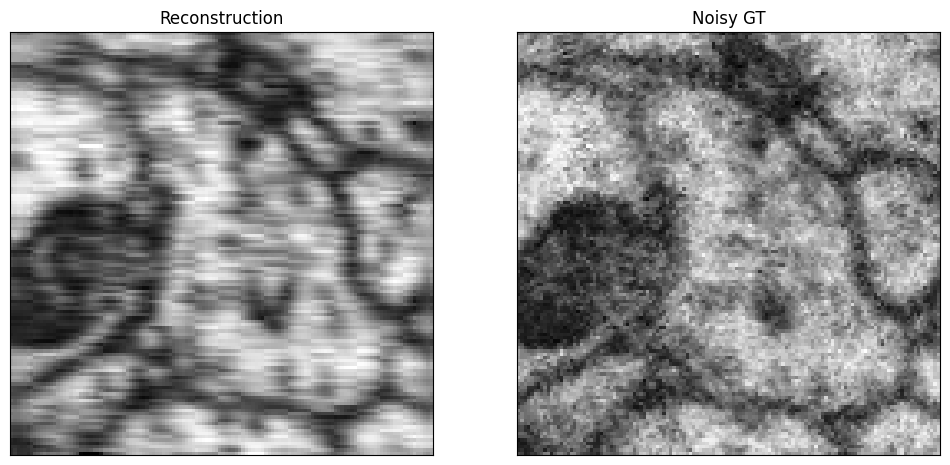

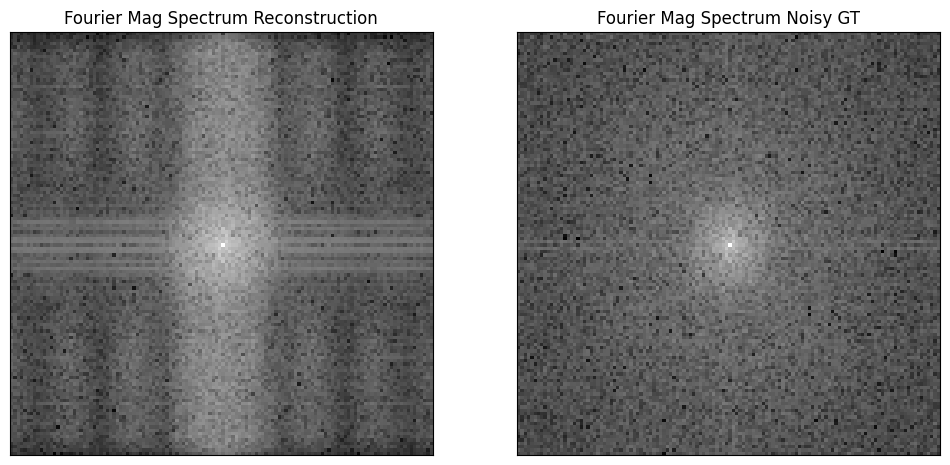

In [19]:
# Display the original, denoised images, and the difference
plt.figure(figsize=(12, 6))

plt.subplot(121), plt.imshow(image1.squeeze().cpu().detach().numpy(), cmap='gray')
plt.title('Reconstruction'), plt.xticks([]), plt.yticks([])

plt.subplot(122), plt.imshow(image2.squeeze().cpu().detach().numpy(), cmap='gray')
plt.title('Noisy GT'), plt.xticks([]), plt.yticks([])

plt.show()


# Display the original, denoised images, and the difference
plt.figure(figsize=(12, 6))

plt.subplot(121), plt.imshow(im1_spectrum.squeeze().cpu().detach().numpy(), cmap='gray')
plt.title('Fourier Mag Spectrum Reconstruction'), plt.xticks([]), plt.yticks([])

plt.subplot(122), plt.imshow(im2_spectrum.squeeze().cpu().detach().numpy(), cmap='gray')
plt.title('Fourier Mag Spectrum Noisy GT'), plt.xticks([]), plt.yticks([])

plt.show()



In [20]:
def fourier_denoiser(img, radius):
    # Compute the 2D Fourier Transform of the image
    f_transform = np.fft.fft2(img)
    f_shifted = np.fft.fftshift(f_transform)

    # Create a low-pass filter mask (circular mask)
    rows, cols = img.shape
    crow, ccol = rows // 2 , cols // 2
    low_pass = np.zeros((rows, cols), dtype=np.uint8)
    y, x = np.ogrid[:rows, :cols]
    mask_area = (x - ccol) ** 2 + (y - crow) ** 2 <= radius**2
    low_pass[mask_area] = 1
    # low_pass[:, 50:75] = 1

    # Apply the mask/filter
    f_shifted_filtered = f_shifted * low_pass

    # Inverse Fourier Transform to get the denoised image back
    f_ishifted = np.fft.ifftshift(f_shifted_filtered)
    img_back = np.fft.ifft2(f_ishifted)
    return np.abs(img_back)


In [21]:
def normalize(image):
    return (image - np.min(image)) / (np.max(image) - np.min(image))

## Fourier-based denoising 

---------------------------------------
PSNR of Noisy Images: 
Bilinear interpolation:  tensor(20.3597)
Reconstructed interpolation:  tensor(20.4745)
---------------------------------------
PSNR of Denoised Images: 
Bilinear interpolation:  tensor(22.8292)
Reconstructed interpolation:  tensor(23.5489)


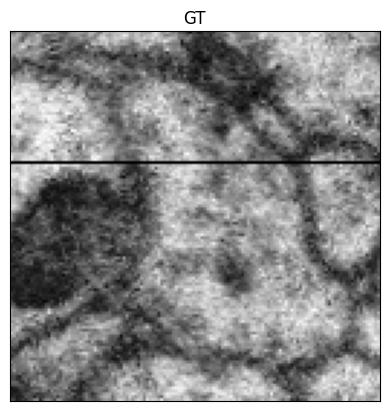

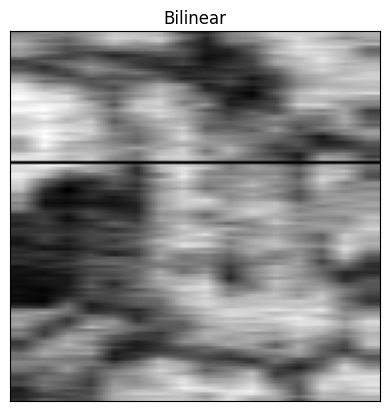

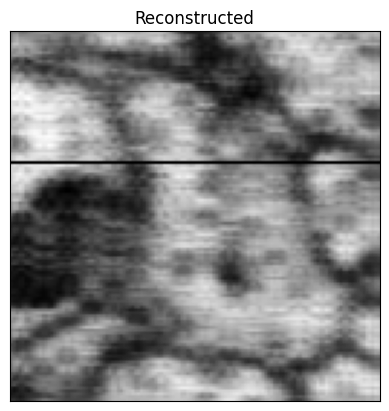

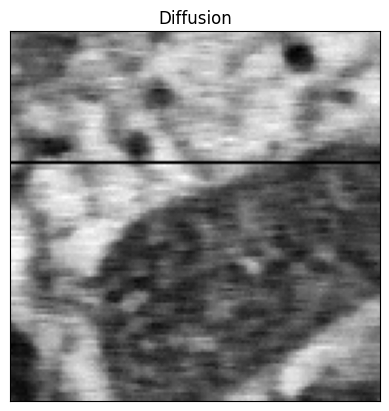

<Figure size 640x480 with 0 Axes>

In [22]:
# Load the image (converting to grayscale)
rec_path = "/home/jakobtroidl/Desktop/neural-volumes/logs/mess/results_iteration_45/15548_15559_15781.npy/result/xz_0_21_227306365966797.png"
rec_image = Image.open(rec_path).convert('L')

gt_path = "/home/jakobtroidl/Desktop/neural-volumes/logs/mess/results_iteration_45/15548_15559_15781.npy/gt/xz_0.png"
gt_image = Image.open(gt_path).convert('L')

bilinear_path = "/home/jakobtroidl/Desktop/neural-volumes/logs/mess/results_iteration_45/15548_15559_15781.npy/bilinear/xz_0_20_809045791625977.png"
bilinear_image = Image.open(bilinear_path).convert('L')

diff_em_path = '/home/jakobtroidl/Desktop/neural-volumes/playground/0_20_218239421570427.png'
diff_em_image = Image.open(diff_em_path).convert('L')

# Define a transform pipeline
transform = transforms.Compose([
    transforms.Grayscale(),         # Convert to grayscale
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5]), # Normalize pixel values
])

normalized_gt = transform(gt_image).squeeze().numpy()
normalized_bilinear = transform(bilinear_image).squeeze().numpy()
normalized_reconstructed = transform(rec_image).squeeze().numpy()
normalized_diff_em = transform(diff_em_image).squeeze().numpy()

# normalize above images between 0 and 1
normalized_gt = normalize(normalized_gt)
normalized_bilinear = normalize(normalized_bilinear)
normalized_reconstructed = normalize(normalized_reconstructed)
normalized_diff_em = normalize(normalized_diff_em)

threshold = 25

rec_denoised = fourier_denoiser(normalized_reconstructed, threshold)
gt_denoised = fourier_denoiser(normalized_gt, threshold)
bilinear_denoised = fourier_denoiser(normalized_bilinear, threshold)
diffusion_denoised = fourier_denoiser(normalized_diff_em, threshold)
gt_denoised = normalize(gt_denoised)


psnr = PeakSignalNoiseRatio(data_range=(0, 1))

# Compute the PSNR of the original and denoised images
psnr_bilinear_noisy = psnr(torch.from_numpy(normalized_bilinear), torch.from_numpy(normalized_gt))
psnr_rec_nosiy = psnr(torch.from_numpy(normalized_reconstructed), torch.from_numpy(normalized_gt))

psnr_bilinear = psnr(torch.from_numpy(bilinear_denoised), torch.from_numpy(gt_denoised))
psnr_rec = psnr(torch.from_numpy(rec_denoised), torch.from_numpy(gt_denoised))

print("---------------------------------------")
print("PSNR of Noisy Images: ")
print("Bilinear interpolation: ", psnr_bilinear_noisy)
print("Reconstructed interpolation: ", psnr_rec_nosiy)

print("---------------------------------------")
print("PSNR of Denoised Images: ")
print("Bilinear interpolation: ", psnr_bilinear)
print("Reconstructed interpolation: ", psnr_rec)

row = 45

normalized_gt[row] = 0.0
normalized_bilinear[row] = 0.0
normalized_reconstructed[row] = 0.0
normalized_diff_em[row] = 0.0

plt.clf()

plt.title('GT'), plt.xticks([]), plt.yticks([])
plt.imshow(normalized_gt, cmap='gray')
plt.show()
plt.clf()

plt.title('Bilinear'), plt.xticks([]), plt.yticks([])
plt.imshow(normalized_bilinear, cmap='gray')
plt.show()
plt.clf()

plt.title('Reconstructed'), plt.xticks([]), plt.yticks([])
plt.imshow(normalized_reconstructed, cmap='gray')
plt.show()
plt.clf()

plt.title('Diffusion'), plt.xticks([]), plt.yticks([])
plt.imshow(normalized_diff_em, cmap='gray')
plt.show()
plt.clf()

### Plot Difference Images

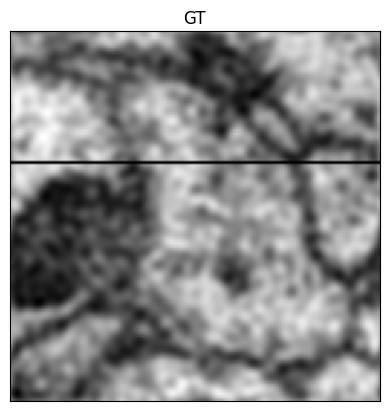

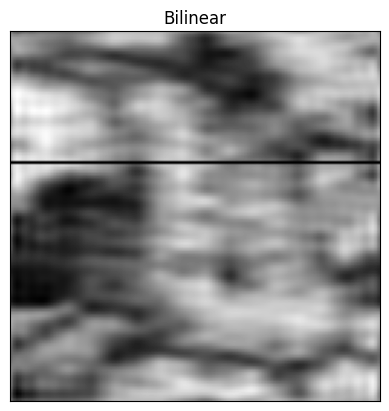

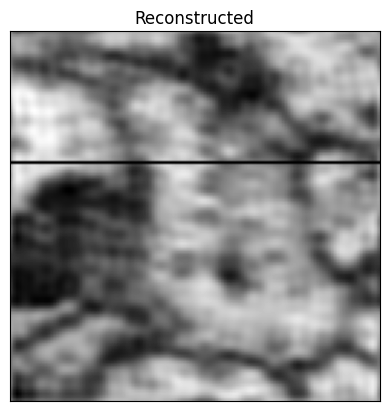

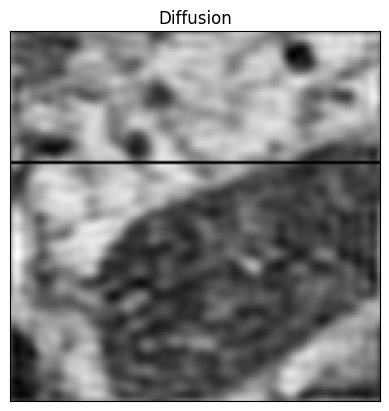

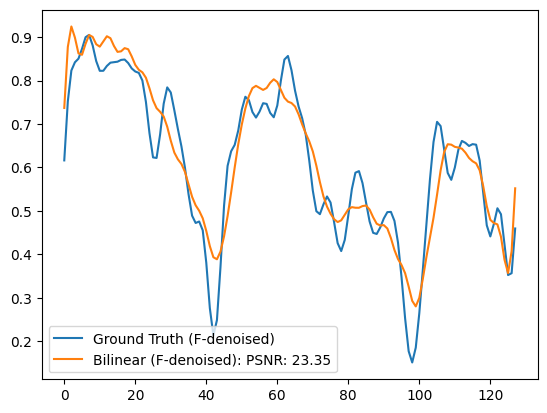

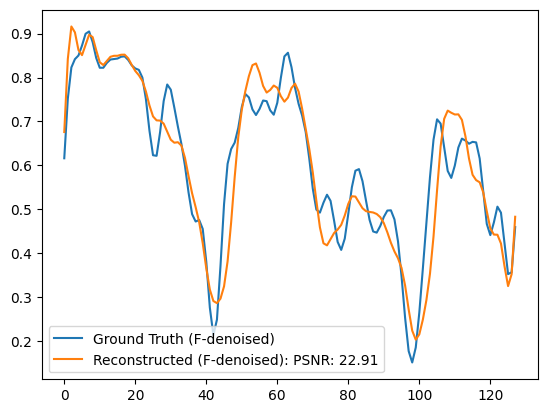

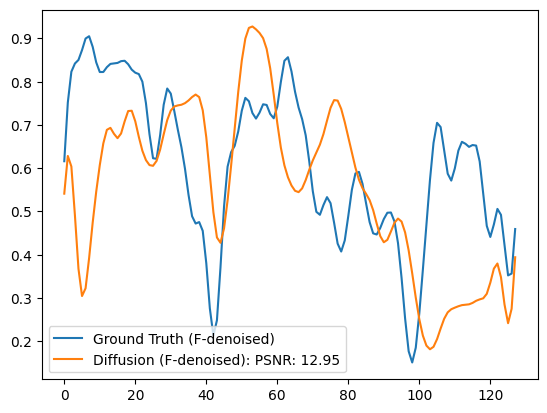

Done


<Figure size 640x480 with 0 Axes>

In [23]:


gt_row = gt_denoised.copy()[row].squeeze()
bilinear_row = bilinear_denoised.copy()[row].squeeze()
rec_row = rec_denoised.copy()[row].squeeze()
diff_row = diffusion_denoised.copy()[row].squeeze()

gt_denoised[row] = 0.0
bilinear_denoised[row] = 0.0
rec_denoised[row] = 0.0
diffusion_denoised[row] = 0.0

plt.clf()

plt.title('GT'), plt.xticks([]), plt.yticks([])
plt.imshow(gt_denoised, cmap='gray')
plt.show()
plt.clf()

plt.title('Bilinear'), plt.xticks([]), plt.yticks([])
plt.imshow(bilinear_denoised, cmap='gray')
plt.show()
plt.clf()

plt.title('Reconstructed'), plt.xticks([]), plt.yticks([])
plt.imshow(rec_denoised, cmap='gray')
plt.show()
plt.clf()

plt.title('Diffusion'), plt.xticks([]), plt.yticks([])
plt.imshow(diffusion_denoised, cmap='gray')
plt.show()
plt.clf()

psnr_bilinear = psnr(torch.from_numpy(bilinear_row), torch.from_numpy(gt_row))
psnr_rec = psnr(torch.from_numpy(rec_row), torch.from_numpy(gt_row))
psnr_diff = psnr(torch.from_numpy(diff_row), torch.from_numpy(gt_row))

plt.plot(gt_row, label="Ground Truth (F-denoised)")
plt.plot(bilinear_row, label="Bilinear (F-denoised): PSNR: {}".format(round(psnr_bilinear.item(), 2)))
leg = plt.legend(loc='lower left')
plt.show()
plt.clf()


plt.plot(gt_row, label="Ground Truth (F-denoised)")
plt.plot(rec_row, label="Reconstructed (F-denoised): PSNR: {}".format(round(psnr_rec.item(), 2)))

leg = plt.legend(loc='lower left')
plt.show()
plt.clf()

plt.plot(gt_row, label="Ground Truth (F-denoised)")
plt.plot(diff_row, label="Diffusion (F-denoised): PSNR: {}".format(round(psnr_diff.item(), 2)))

leg = plt.legend(loc='lower left')
plt.show()
plt.clf()

print("Done")

